# Exploratory Data Analysis: Diabetic Readmission Risk
**Objective:** To investigate the quality, distribution, and structure of the dataset before modeling.

Our primary goals in this phase are:
1.  **Assess Data Quality:** Identify features with excessive missingness.
2.  **Analyze Class Balance:** Quantify the ratio of readmitted vs. non-readmitted patients to anticipate the "Accuracy Paradox."
3.  **Validate Feature Engineering:** Visualizing the impact of grouping high-cardinality features like ICD-9 diagnosis codes.

In [29]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Filter out annoying warnings for a clean report
warnings.filterwarnings('ignore')

# Add the parent directory to path so we can import from 'src'
sys.path.append(os.path.abspath(os.path.join('..')))

from src import preprocess
from src import feature_engineering

# Plot Settings
plt.style.use('ggplot')
sns.set_palette('colorblind')

# 1. Load Raw Data (Before Cleaning) to show the "Mess"
raw_df = pd.read_csv('../data/diabetic_data.csv', na_values='?')
print(f"Original Shape: {raw_df.shape}")
# Display the first 5 rows of the dataframe to check the structure
raw_df.head()

Original Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## 1. Analysis of Missing Data
Before attempting to train any model, we must identify features that lack sufficient signal. Features with extremely high missingness (>40%) often introduce more noise than value when imputed.

**Hypothesis:** Columns related to administrative details (like `payer_code`) or specific biometrics (like `weight`) may be sparsely populated in this dataset.

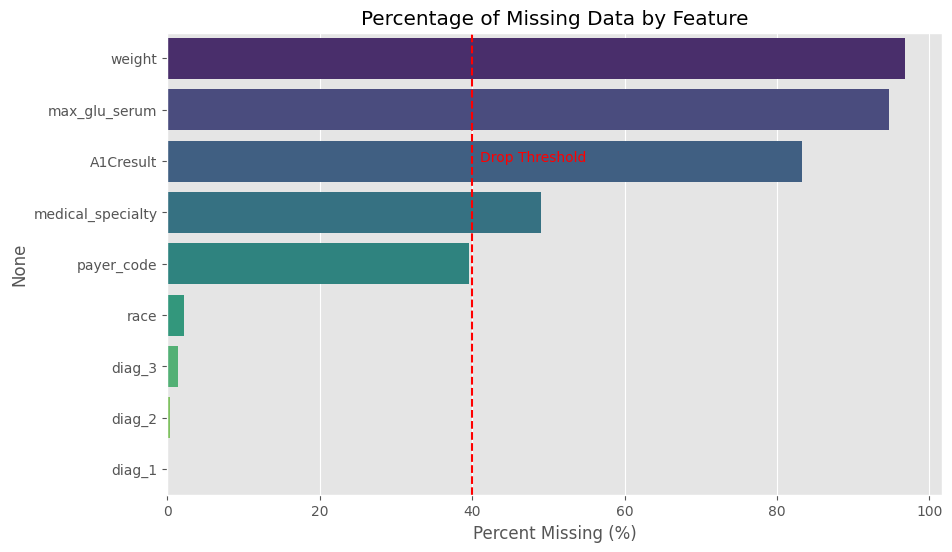

DECISION: Dropped 'weight', 'payer_code', and 'medical_specialty' due to excessive missingness.


In [30]:
# Visualize Missing Values
plt.figure(figsize=(10, 6))
missing = raw_df.isnull().sum() / len(raw_df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

sns.barplot(x=missing.values, y=missing.index, palette='viridis')
plt.title('Percentage of Missing Data by Feature')
plt.xlabel('Percent Missing (%)')
plt.axvline(x=40, color='r', linestyle='--')
plt.text(41, 2, 'Drop Threshold', color='r')
plt.show()

print("DECISION: Dropped 'weight', 'payer_code', and 'medical_specialty' due to excessive missingness.")

In [31]:
# 1. Create the dataframe with columns dropped (but keep the rows for now)
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df_check = raw_df.drop(columns=cols_to_drop, errors='ignore')

# 2. See which remaining columns have the most missing values
print(df_check.isnull().sum().sort_values(ascending=False).head(10))

max_glu_serum          96420
A1Cresult              84748
race                    2273
diag_3                  1423
diag_2                   358
diag_1                    21
admission_source_id        0
num_lab_procedures         0
time_in_hospital           0
gender                     0
dtype: int64


In [32]:
# 2. Data Cleaning Strategy (Corrected)
# Drop columns with excessive missing values (>40-50%) and identifiers
cols_to_drop = [
    'encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty',
    'max_glu_serum', 'A1Cresult'  # <--- Added these two culprits
]

df = raw_df.drop(columns=cols_to_drop, errors='ignore')

# Drop rows for the remaining small amount of missing data (like 'race' and 'diag')
df = df.dropna()

print(f"Original Shape: {raw_df.shape}")
print(f"Clean Shape:    {df.shape}")  # This should now be large (~98,000)
df.head()

Original Shape: (101766, 50)
Clean Shape:    (98053, 43)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,>30


### Decision: Feature Pruning
The visualization above reveals that `weight`, `payer_code`, and `medical_specialty` have significant missingness (up to 97% for weight).
* **Action:** We will drop these columns in the preprocessing pipeline.
* **Reasoning:** Imputing a variable that is 97% missing is statistically unsound and would lead to a model learning from synthetic noise rather than actual patient data.

---

## 2. Target Variable Distribution (The "Accuracy Paradox")
We now examine the balance of our target variable: `readmitted`. Since we are specifically interested in early readmissions (<30 days), we treat this as the Positive Class (1).

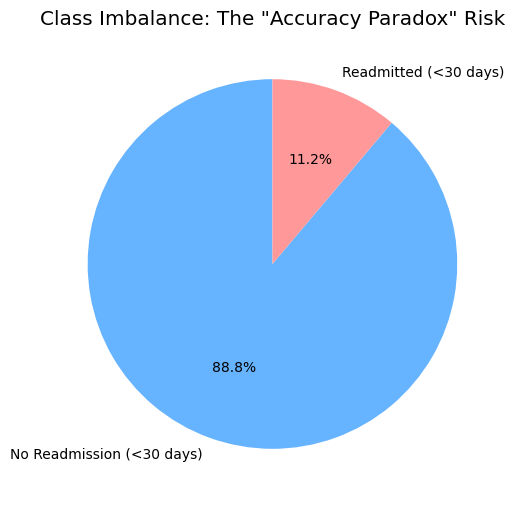

INSIGHT: Only 11% of cases are positive. A default model will get ~89% accuracy by predicting 0.


In [33]:
# Target Balance
target_counts = raw_df['readmitted'].apply(lambda x: 1 if x == '<30' else 0).value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['No Readmission (<30 days)', 'Readmitted (<30 days)'], 
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Class Imbalance: The "Accuracy Paradox" Risk')
plt.show()

print("INSIGHT: Only 11% of cases are positive. A default model will get ~89% accuracy by predicting 0.")

### Insight: Severe Class Imbalance
The pie chart confirms a severe imbalance: only **11.1%** of patients are readmitted within 30 days.

* **Risk:** A naive model could achieve **~89% accuracy** simply by predicting "No Readmission" for every patient. This is the **Accuracy Paradox**.
* **Strategy:** This justifies our decision to use **SMOTE (Synthetic Minority Over-sampling Technique)** in the training pipeline and to optimize for **F1-Score/Recall** rather than raw accuracy.

---

## 3. Feature Engineering: ICD-9 Diagnosis Grouping
The raw dataset contains hundreds of unique ICD-9 medical codes (e.g., `250.01`, `414.00`). Feeding these directly into a model as One-Hot Encoded features would create a sparse, high-dimensional dataset prone to overfitting.

**Strategy:** We group these codes into 9 distinct clinical categories (e.g., "Circulatory", "Diabetes", "Respiratory") to capture the *medical theme* rather than the specific code.

Loading dataset...
Engineering 'diag_1_group' feature...


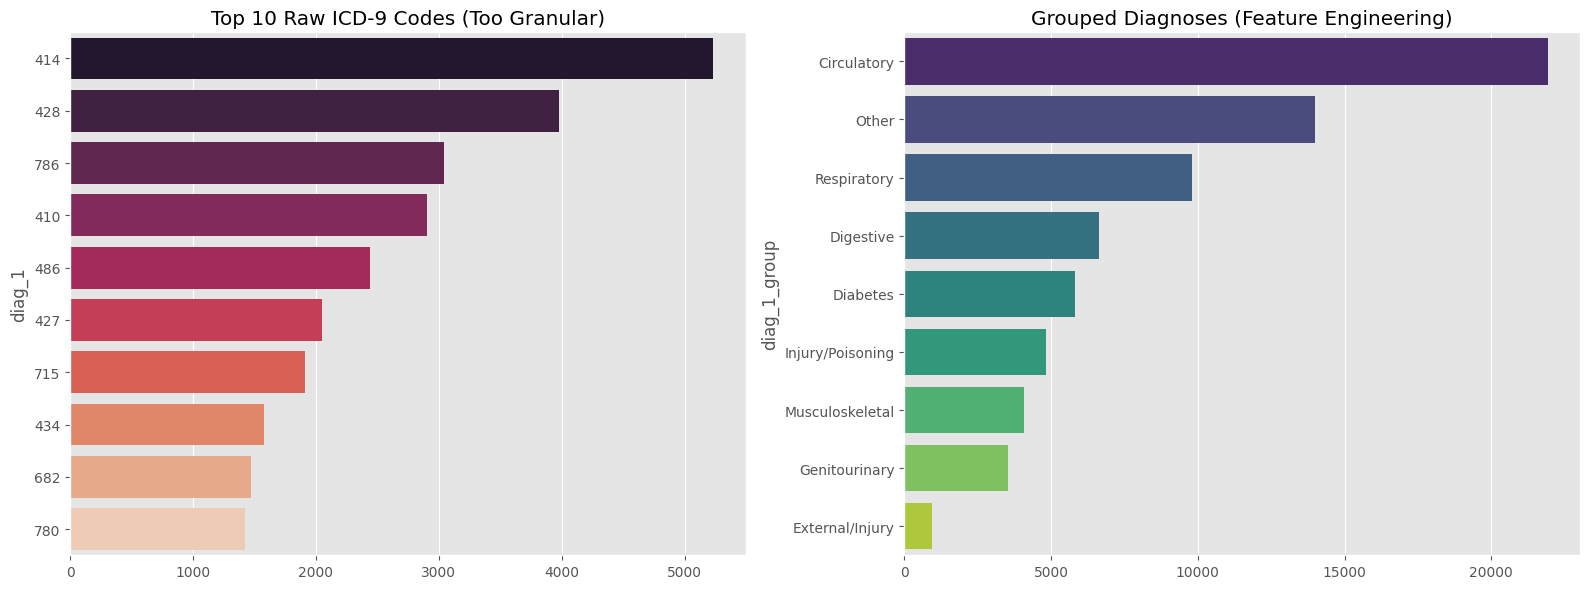

In [34]:
# Visualize Diagnosis Grouping Logic
# We show top 10 raw codes vs our grouped codes
df_clean = preprocess.load_and_clean_data('../data/diabetic_data.csv')
df_eng = feature_engineering.apply_feature_engineering(df_clean)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw Chaos
raw_counts = df_clean['diag_1'].value_counts().head(10)
sns.barplot(x=raw_counts.values, y=raw_counts.index, ax=axes[0], palette='rocket')
axes[0].set_title('Top 10 Raw ICD-9 Codes (Too Granular)')

# Plot 2: Engineered Clarity
group_counts = df_eng['diag_1_group'].value_counts()
sns.barplot(x=group_counts.values, y=group_counts.index, ax=axes[1], palette='viridis')
axes[1].set_title('Grouped Diagnoses (Feature Engineering)')

plt.tight_layout()
plt.show()

In [35]:
# 3.2 Recoding Administrative IDs
# IDs 1, 6, and 8 generally correspond to 'Discharged to Home'
def recode_discharge(x):
    if x in [1, 6, 8]: return 'Home'
    return 'Other/Transferred'

df['discharge_cluster'] = df['discharge_disposition_id'].apply(recode_discharge)

# View the transformation
print(df[['discharge_disposition_id', 'discharge_cluster']].head(20))

    discharge_disposition_id  discharge_cluster
1                          1               Home
2                          1               Home
3                          1               Home
4                          1               Home
5                          1               Home
6                          1               Home
7                          1               Home
8                          1               Home
9                          3  Other/Transferred
10                         1               Home
11                         1               Home
12                         3  Other/Transferred
13                         6               Home
14                         1               Home
15                         3  Other/Transferred
16                         1               Home
17                         1               Home
18                         1               Home
22                         1               Home
23                         6            

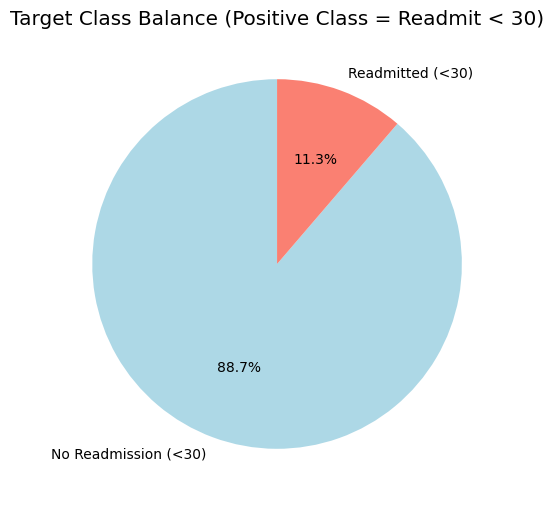

In [36]:
# 3.3 Target Engineering
# 1 = Readmitted < 30 days (High Risk), 0 = Otherwise
df['target'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Visualize Class Balance
plt.figure(figsize=(6, 6))
df['target'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No Readmission (<30)', 'Readmitted (<30)'], startangle=90, colors=['lightblue', 'salmon'])
plt.title('Target Class Balance (Positive Class = Readmit < 30)')
plt.ylabel('')
plt.show()

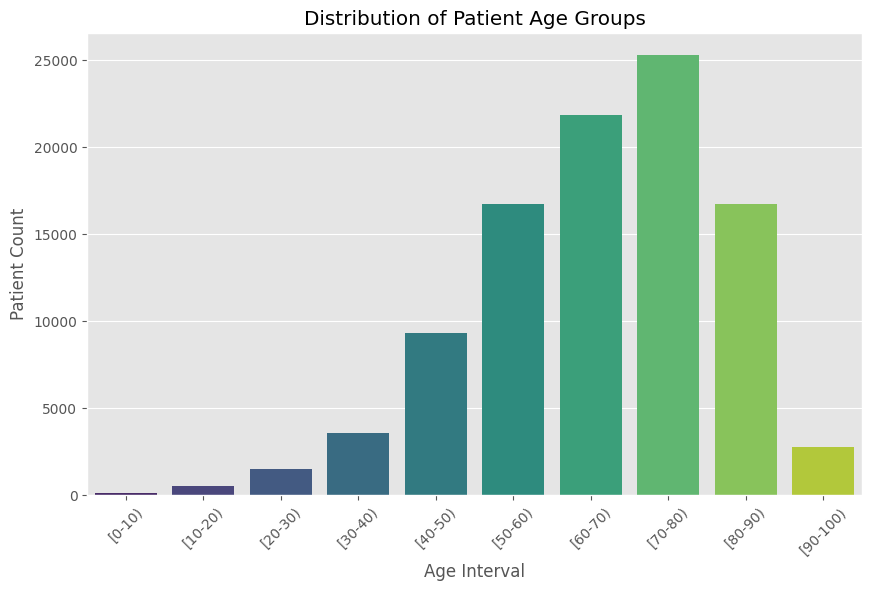

In [46]:
# 4.1 Age Distribution
plt.figure(figsize=(10, 6))
# Ensure age groups are sorted (0-10, 10-20, etc.)
age_order = sorted(df['age'].unique())
sns.countplot(x='age', data=df, order=age_order, palette='viridis')
plt.title('Distribution of Patient Age Groups')
plt.xlabel('Age Interval')
plt.ylabel('Patient Count')
plt.xticks(rotation=45)
plt.show()

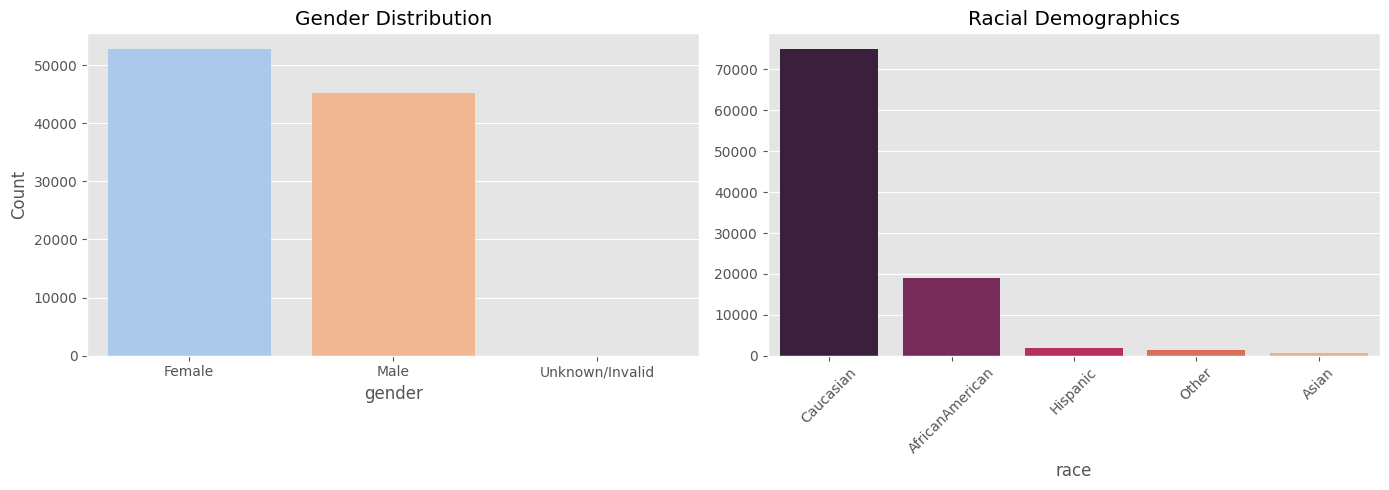

In [45]:
# 4.2 Gender & Race
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender Plot
sns.countplot(x='gender', data=df, ax=axes[0], palette='pastel')
axes[0].set_title('Gender Distribution')
axes[0].set_ylabel('Count')

# Race Plot
# Count values to handle missing '?' labels cleanly if present
race_counts = df['race'].value_counts()
sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], palette='rocket')
axes[1].set_title('Racial Demographics')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

array([<Axes: title={'center': 'A1C Results (Diabetic Control)'}, ylabel='Proportion'>,
       <Axes: title={'center': 'Max Glucose Levels'}, xlabel='readmitted_label', ylabel='Proportion'>],
      dtype=object)

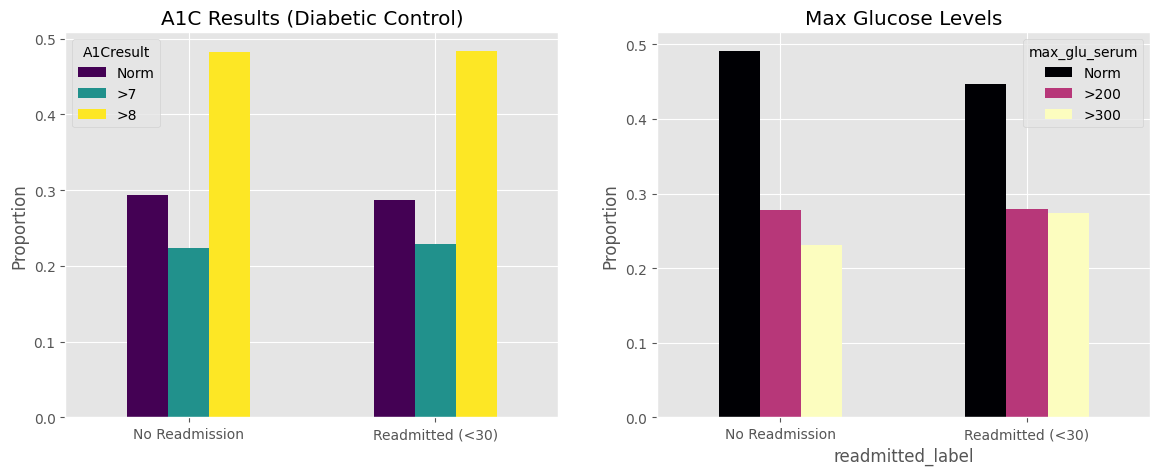

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- SETUP (Required) ---
# Create the readable labels for the plots
raw_df['target'] = raw_df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
raw_df['readmitted_label'] = raw_df['target'].apply(lambda x: 'Readmitted (<30)' if x == 1 else 'No Readmission')

# --- VISUALIZATION 1: Lab Results (HbA1c & Glucose) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# A1C Plot
a1c_order = ['None', 'Norm', '>7', '>8']
a1c_props = raw_df.groupby('readmitted_label')['A1Cresult'].value_counts(normalize=True).unstack().fillna(0)
# Reorder columns safely
cols_to_use = [c for c in a1c_order if c in a1c_props.columns]
a1c_props[cols_to_use].plot(kind='bar', ax=axes[0], colormap='viridis', rot=0)
axes[0].set_title('A1C Results (Diabetic Control)')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('')

# Glucose Plot
glu_order = ['None', 'Norm', '>200', '>300']
glu_props = raw_df.groupby('readmitted_label')['max_glu_serum'].value_counts(normalize=True).unstack().fillna(0)
cols_to_use = [c for c in glu_order if c in glu_props.columns]
glu_props[cols_to_use].plot(kind='bar', ax=axes[1], colormap='magma', rot=0)
axes[1].set_title('Max Glucose Levels')
axes[1].set_ylabel('Proportion')
axes

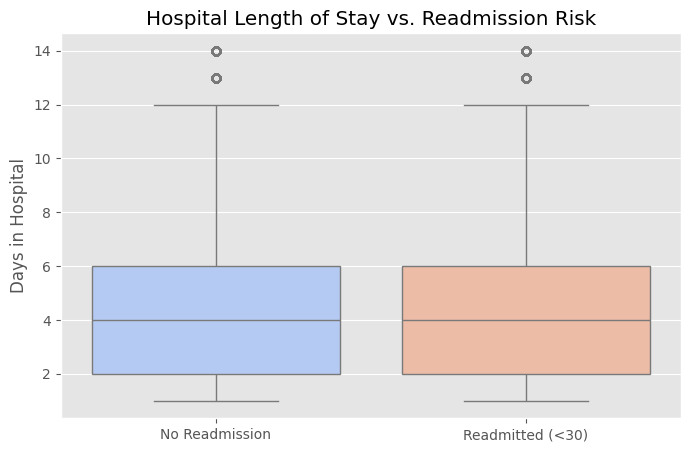

In [48]:
# --- VISUALIZATION 2: Time in Hospital ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='readmitted_label', y='time_in_hospital', data=raw_df, palette='coolwarm')
plt.title('Hospital Length of Stay vs. Readmission Risk')
plt.ylabel('Days in Hospital')
plt.xlabel('')
plt.show()

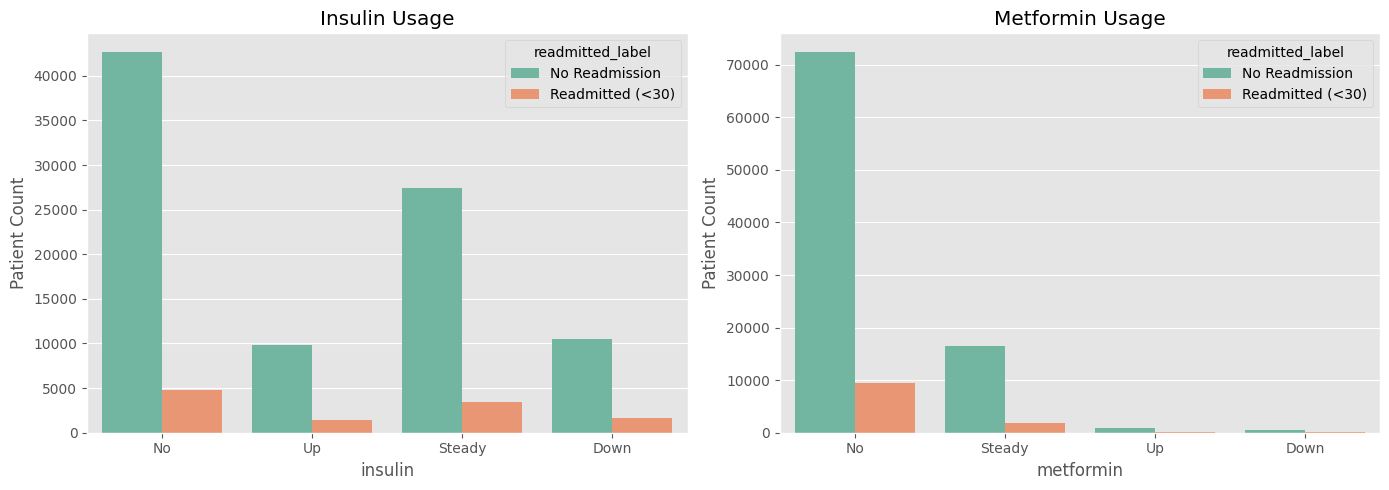

In [49]:
# --- VISUALIZATION 3: Medication Impact ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Insulin Usage
sns.countplot(x='insulin', data=raw_df, hue='readmitted_label', ax=axes[0], palette='Set2')
axes[0].set_title('Insulin Usage')
axes[0].set_ylabel('Patient Count')

# Metformin Usage
sns.countplot(x='metformin', data=raw_df, hue='readmitted_label', ax=axes[1], palette='Set2')
axes[1].set_title('Metformin Usage')
axes[1].set_ylabel('Patient Count')

plt.tight_layout()
plt.show()

### Conclusion
The comparison above illustrates the value of our feature engineering:
1.  **Left Plot (Raw):** Shows the chaos of granular codes. The model would struggle to find patterns here without thousands of examples per code.
2.  **Right Plot (Grouped):** Shows clear, dense categories. This dimensionality reduction helps tree-based models (like Random Forest) find split points more effectively.

**Next Steps:** These insights (Drop Columns, Handle Imbalance, Group Diagnoses) are now implemented in our production pipeline (`src/preprocess.py` and `src/feature_engineering.py`).